The first two cells are to set up the GAMS environment and enable some commands in exchanging data between GAMS and Python

In [1]:
%load_ext gams_magic

In [2]:
%%capture
%run ~/share/DataTransform.ipynb
from IPython.display import display

# Finding Chebyshev center of a polyhedron

Find the largest circle that can drawn on the inside of the polyhedron 

Ai1 x1 + Ai2 x2 <= bi, i=1,... m

Define ni to be the square root of (Ai1^2 + Ai2^2). 

Then the LP is 

max_{xbar1,xbar2,r} r
subject to: Ai1 * xbar1 + Ai2 * xbar2 + r * ni <= bi, i=1, ... m, 
            r >=0.

In [3]:
%%gams 
sets I "set of constraint indices", J /Ai1, Ai2, bi/;
parameter constraints(I<,J);


In [4]:
#This is a python cell

#import pandas: a Python package providing data structures designed to make working with labeled data
import pandas as pd

constraints=pd.read_csv("ChebyshevConstraints.csv")

#Shift the default index by 1 for convenience
constraints.index=constraints.index+1

#Convert the index into a string so that gams_push will work properly
constraints.index= constraints.index.map(str) 

#display all data in constraints
display(constraints)

#Use the function gt_from2dim in DataTransform to transform constraints
constraints = gt_from2dim(constraints)

display(constraints)



,Ai1,Ai2,bi
1,-1,-1,-2
2,-1,0,0
3,0,-1,0
4,-2,3,12
5,3,-2,15
6,4,5,50


,level_0,level_1,0
0,1,Ai1,-1
1,1,Ai2,-1
2,1,bi,-2
3,2,Ai1,-1
4,2,Ai2,0
5,2,bi,0
6,3,Ai1,0
7,3,Ai2,-1
8,3,bi,0
9,4,Ai1,-2


In [5]:
%gams_push constraints
%gams display constraints, i,j;
%gams_lst -e

E x e c u t i o n


----     12 PARAMETER constraints  Domain loaded from constraints position 1

          Ai1         Ai2          bi

1      -1.000      -1.000      -2.000
2      -1.000
3                  -1.000
4      -2.000       3.000      12.000
5       3.000      -2.000      15.000
6       4.000       5.000      50.000


----     12 SET I  set of constraint indices

1,    2,    3,    4,    5,    6


----     12 SET J  

Ai1,    Ai2,    bi 





In [6]:
%%gams

parameters norm(I);

norm(I) = sqrt(sqr(constraints(I,'Ai1')) + sqr(constraints(I,'Ai2')));

variables xbar1, xbar2;

free variable r;

equations ineq(I);

ineq(I).. constraints(I,'Ai1') * xbar1 + 
          constraints(I,'Ai2')*xbar2 +
          r * norm(I)
            =l= constraints(I,'bi');

r.lo = 0;

model ChebyshevCenter /all/;

#GAMS option limrow specifies the number of equations to include in GAMS listing file
option limrow = 3;

#GAMS option solprint on/off: whether to not to include the solution report part in the listing file
option solprint = on;

solve ChebyshevCenter using LP maximizing r;


,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),2.8661,6,3,LP,OSICPLEX,0


In [7]:
%gams_lst

GAMS 28.2.0  r750fa45 Released Aug 19, 2019 LEX-LEG x86 64bit/Linux                                                                                                                                                                    10/16/19 17:21:39 Page 6
G e n e r a l   A l g e b r a i c   M o d e l i n g   S y s t e m
C o m p i l a t i o n


  15   
  16  parameters norm(I);
  17   
  18  norm(I) = sqrt(sqr(constraints(I,'Ai1')) + sqr(constraints(I,'Ai2')));
  19   
  20  variables xbar1, xbar2;
  21   
  22  free variable r;
  23   
  24  equations ineq(I);
  25   
  26  ineq(I).. constraints(I,'Ai1') * xbar1 + constraints(I,'Ai2')*xbar2 + r * norm(I)
  27              =l= constraints(I,'bi');
  28   
  29  r.lo = 0;
  30   
  31  model ChebyshevCenter /all/;
  32   
  33  #GAMS option limrow specifies the number of equations to include in GAMS listing file
  34  option limrow = 3;
  35   
  36  #GAMS option solprint on/off: whether to not to include the solution report part in the

In [8]:
%gams display xbar1.l, xbar2.l;
%gams_lst -e

E x e c u t i o n


----     42 VARIABLE xbar1.L               =        3.466  
            VARIABLE xbar2.L               =        2.866  




,level,marginal,lower,upper,scale
0,3.466106,0.0,-inf,inf,1.0


,level,marginal,lower,upper,scale
0,2.866106,0.0,-inf,inf,1.0


,level,marginal,lower,upper,scale
0,2.866106,0.0,0.0,inf,1.0


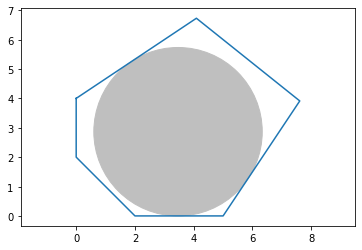

In [11]:
%gams_pull -d xbar1 xbar2 r
display(xbar1, xbar2, r)

import matplotlib.pyplot as plt

coord = [[0,4], [0,2], [2,0], [5,0], [175/23,90/23], [45/11,74/11]]
coord.append(coord[0]) #repeat the first point to create a 'closed loop'

xs, ys = zip(*coord) #create lists of x and y values

plt.figure()

plt.axis('equal')

plt.plot(xs,ys) 

circle1=plt.Circle((xbar1.level[0],xbar2.level[0]),r.level[0],color='0.75')
plt.gcf().gca().add_artist(circle1)

plt.show()

ValueError: max() arg is an empty sequence